<a href="https://colab.research.google.com/github/INFINITY-RUBER/Curso_de_Tensorflow-2.0_Guia_completa_para_el_Nuevo_Tensorflow/blob/master/Collab_12_2_API_REST_para_Clasificar_Im%C3%A1genes_con_TensorFlow_Serving_rest_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Entrene y deploy un modelo de TensorFlow con TensorFlow Serving

**Advertencia: este portátil está diseñado para ejecutarse solo en Google Colab **. Instala paquetes en el sistema y requiere acceso de root. Si desea ejecutarlo en un cuaderno de Jupyter local, proceda con precaución.


<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<tr><td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/serving/rest_simple">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
</tr></table></div>

Esta guía entrena un modelo de red neuronal para clasificar imágenes de ropa, como zapatillas y camisetas , guarda el modelo entrenado y luego lo muestra con TensorFlow Serving . La atención se centra en TensorFlow Serving, en lugar del modelado y el entrenamiento en TensorFlow, por lo que para obtener un ejemplo completo que se centra en el modelado y el entrenamiento, consulte el ejemplo de Clasificación básica .

Esta guía usa tf.keras , una API de alto nivel para compilar y entrenar modelos en TensorFlow.

In [ ]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [ ]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment
     |████████████████████████████████| 2.4MB 4.7MB/s 
TensorFlow version: 2.3.0


## Create your model

### Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow, just import and load the data.

Note: Although these are really images, they are loaded as NumPy arrays and not binary image objects.

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4423680/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


### Entrena y evalúa tu modelo
Usemos la CNN más simple posible, ya que no estamos enfocados en la parte del modelad

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5517 - accuracy: 0.8091
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4233 - accuracy: 0.8527
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3920 - accuracy: 0.8625
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.36

## Guarda tu modelo
Para cargar nuestro modelo entrenado en TensorFlow Serving, primero debemos guardarlo en formato SavedModel . Esto creará un archivo protobuf en una jerarquía de directorios bien definida e incluirá un número de versión. TensorFlow Serving nos permite seleccionar qué versión de un modelo o "servible" queremos usar cuando hacemos solicitudes de inferencia. Cada versión se exportará a un subdirectorio diferente en la ruta indicada.

In [ ]:
# btener la sesión de Keras y guardar el modelo
# La definición de la firma está definida por el tensor de entrada y salida,
# y almacenado con la clave de servicio predeterminada
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 84
drwxr-xr-x 2 root root  4096 Aug 18 00:03 assets
-rw-r--r-- 1 root root 74831 Aug 18 00:03 saved_model.pb
drwxr-xr-x 2 root root  4096 Aug 18 00:03 variables


## Examina tu modelo guardado
Usaremos la utilidad de línea de comando saved_model_cli para ver MetaGraphDefs (los modelos) y SignatureDefs (los métodos que puede llamar) en nuestro SavedModel. Consulta esta discusión sobre la CLI del modelo guardado en la Guía de TensorFlow.

In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0818 00:07:37.935771 139957287544704 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/pytho

¡Eso nos dice mucho sobre nuestro modelo! En este caso, acabamos de entrenar nuestro modelo, por lo que ya conocemos las entradas y salidas, pero si no lo hiciéramos, esta sería información importante. No nos dice todo, como el hecho de que se trata de datos de imagen en escala de grises, por ejemplo, pero es un gran comienzo.

## Servir su modelo con TensorFlow Serving

### Agrega el URI de distribución de TensorFlow Serving como fuente del paquete:
Nos estamos preparando para instalar TensorFlow Serving con Aptitude, ya que este Colab se ejecuta en un entorno Debian. Agregaremos el tensorflow-model-server paquete a la lista de paquetes que conoce Aptitude. Tenga en cuenta que estamos ejecutando como root.

Note: Nota: Este ejemplo ejecuta TensorFlow Serving de forma nativa, pero también puedes ejecutarlo en un contenedor Docker , que es una de las formas más fáciles de comenzar a usar TensorFlow Serving. [Docker container](https://www.tensorflow.org/tfx/serving/docker), 

In [ ]:
# Esto es lo mismo que lo haría desde su línea de comando, pero sin el [arch = amd64], y sin sudo 
# En su lugar, harías:

# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  15822      0 --:--:-- --:--:-- --:--:-- 15822
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1

### Instalar TensorFlow Serving
Esto es todo lo que necesita: ¡una línea de comando!

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 54 not upgraded.
Need to get 210 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.3.0 [210 MB]
Fetched 210 MB in 2s (85.7 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.3.0_all.deb ...
Unpacking tensorflow-model-server (2.3.0) ...
Setting up tensorflow-model-server (2.3.0) ...


### Comience a ejecutar TensorFlow Serving
Aquí es donde comenzamos a ejecutar TensorFlow Serving y cargamos nuestro modelo. Después de que se cargue, podemos comenzar a realizar solicitudes de inferencia usando REST. Hay algunos parámetros importantes:

* `rest_api_port`: El puerto que utilizará para las solicitudes REST.
* `model_name`: Utilizará esto en la URL de las solicitudes REST. Puede ser cualquier cosa.
* `model_base_path`: Esta es la ruta al directorio donde ha guardado su modelo.


### Exportar el MODEL_DIR a las variables de entorno

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-08-18 00:19:23.949009: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:199] Restoring SavedModel bundle.
2020-08-18 00:19:23.968997: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /tmp/1
2020-08-18 00:19:23.971935: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:303] SavedModel load for tags { serve }; Status: success: OK. Took 38045 microseconds.
2020-08-18 00:19:23.972404: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-08-18 00:19:23.972508: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_model version: 1}
2020-08-18 00:19:23.973650: I tensorflow_serving/model_servers/server.cc:367] Running gRPC ModelServer at 0.0.0.0:8500 ...
[wa

## Realice una solicitud a su modelo en TensorFlow Serving
Primero, echemos un vistazo a un ejemplo aleatorio de nuestros datos de prueba.

In [ ]:
#Funcion para visualizar un elemento rondom
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})



9932


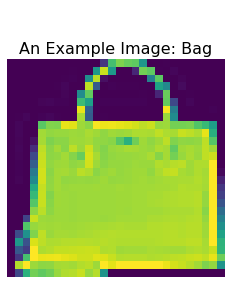

In [ ]:
import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))
print(rando)

Ok, eso parece interesante. ¿Qué tan difícil es para usted reconocer? Ahora creemos el objeto JSON para un lote de tres solicitudes de inferencia y veamos qué tan bien reconoce nuestro modelo las cosas:

In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:5].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))
# test_images[0:5] >> cantidad de imagenes que se le pasa

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


### Realizar solicitudes de REST
Versión más nueva del servidor
Enviaremos una solicitud de predicción como POST al punto final REST de nuestro servidor y le pasaremos tres ejemplos. 
Le pediremos a nuestro servidor que nos dé la última versión de nuestro servidor sin especificar una versión en particular.

In [ ]:
!pip install -q requests

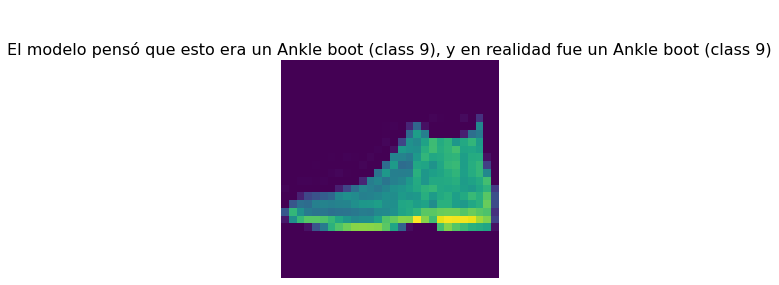

In [ ]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'El modelo pensó que esto era un {} (class {}), y en realidad fue un {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

#### Una versión particular del servidor
Ahora especifiquemos una versión particular de nuestro servidor. Como solo tenemos uno, 
seleccionemos la versión 1. 

También veremos los tres resultados.

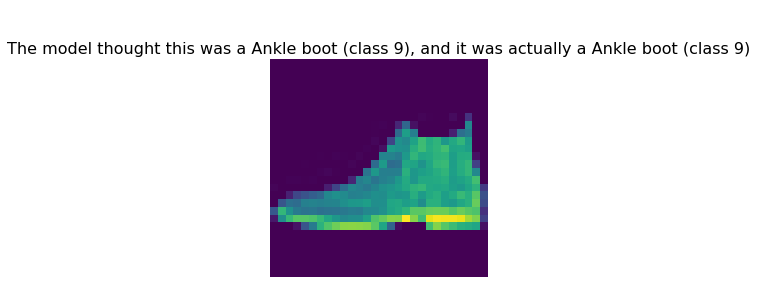

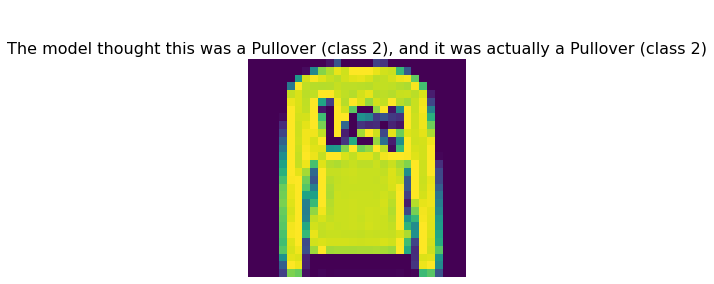

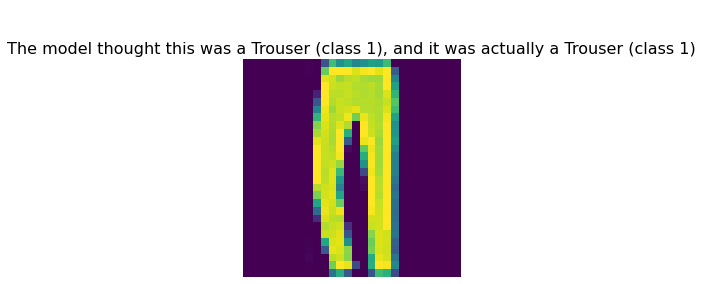

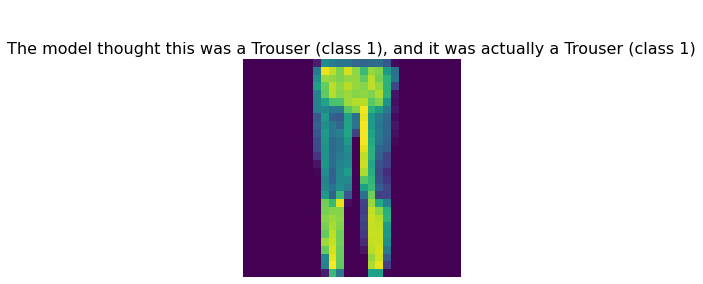

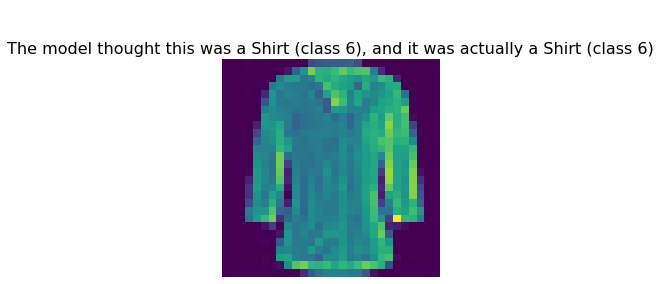

In [ ]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,5):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))